In [1]:
var = 7
Re = 50.0
# Options for variance: 7, 10, 100
# Options for Re: 50.0

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

import re
import os
from os import path
import numpy as np

import blusky.datasets as datasets
import matplotlib.ticker as mtick

import matplotlib.pylab as plt
import matplotlib.pylab as pl
import sys
from pprint import pprint


from keras.layers import Input
from keras import Model
import keras.backend as keras_backend
from keras.layers import Conv1D, Lambda, Add

from traits.api import Enum, HasStrictTraits, Int, Instance, List, Tuple
from blusky.transforms.apply_father_wavelet_1d import ApplyFatherWavlet1D
from blusky.transforms.cascade_tree import CascadeTree
from blusky.transforms.cascade_1d import Cascade1D
from blusky.transforms.default_decimation import (NoDecimation, 
                                                  DefaultDecimation)
from blusky.wavelets.wavelet_factories_1d import (vanilla_gabor_1d, 
                                                  vanilla_morlet_1d,
                                                  calibrate_wavelets_1d)
from blusky.transforms.i_decimation_method import IDecimationMethod
from blusky.wavelets.i_wavelet_1d import IWavelet1D
from blusky.utils.pad_1d import pad_to_log2, Pad1D




Using TensorFlow backend.


In [4]:

params = { #'font.family'      : 'serif',
           'font.size'        : 10,
           'xtick.labelsize'  : 'medium',
           'ytick.labelsize'  : 'medium',
           'axes.labelsize'   : 'large',
           'axes.linewidth'   : 1.8,
           'figure.autolayout': True }
plt.rcParams.update(params)



In [5]:

def load_data(Re, total, var):
    tss = []
    # iterate through time
    for k in range(0, total):
        if var == 7:
            ts_path = path.join("testvariance/" + "gaussian_time_" + str(k) + "reynolds_" + str(Re) + "var" + str(var), 'final' )
        if var == 10:            
            ts_path = path.join("smallvariance/" + "gaussian_time_" + str(k) + "reynolds_" + str(Re) + "var" + str(var), 'final' )
        if var == 100:
            ts_path = path.join("largevariance/" + "gaussian_time_" + str(k) + "reynolds_" + str(Re) + "var" + str(var), 'final' )
        data = np.genfromtxt(ts_path, delimiter=',', skip_header=1)       
        ts = data
        tss.append(ts)

    samples = np.array(tss) 
    return samples



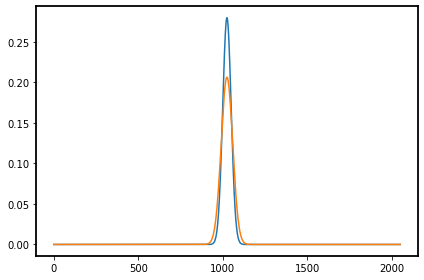

In [24]:
plt.figure()
plt.plot(samples[10])
plt.plot(samples[20])
plt.show()

In [12]:
def transform_model(N = 256, order = 2, sample_rate = 0.001, J = 5):
    order = 2
    sample_rate = 0.001

    # for the father wavelet
    # make this larger to remove the decimatoion
    #oversampling = 100
    oversampling = 0
    # if you want to stop decimation this needs to be "same"
    father_padding = "same"
    # There's no need to change this:
    conv_padding = "valid"

    J = J

    wavelets = [vanilla_morlet_1d(sample_rate, J, j=i) 
                        for i in range(0,J)]
    calibrate_wavelets_1d(wavelets)

    father_wavelet = vanilla_gabor_1d(sample_rate, J)

    deci = DefaultDecimation(oversampling=oversampling)
    #deci = NoDecimation()

    inp = Input(shape=(N,1))

    # pad
    pad_1d = Pad1D(wavelets, decimation=deci, conv_padding=conv_padding)
    padded = pad_1d.pad(inp)

    #
    cascade_tree = CascadeTree(padded, order=order)

    cascade = Cascade1D(decimation=deci, _padding=conv_padding)
    convs = cascade.transform(cascade_tree, wavelets=wavelets)

    # Create layers to remove padding
    cascade_tree = CascadeTree(padded, order=order)
    cascade_tree.generate(wavelets, pad_1d.unpad)
    unpad = cascade_tree.get_convolutions()

    # Remove the padding
    unpadded_convs = [inp,] + [i[1](i[0]) for i in zip(convs, unpad)]

    # the paper sets: fparam.J = Jmax-1
    # 
    appl = ApplyFatherWavlet1D(wavelet=father_wavelet, 
                            J=J, 
                            img_size=(N,), 
                            padding=father_padding,
                            sample_rate=sample_rate,
                            overlap_log_2=0)
    sca_transf = appl.convolve(unpadded_convs)

    # it's far more efficient to build the model once and reuse it:
    model = Model(inputs=inp, outputs=sca_transf)
    
    model.summary()

    return model

In [7]:
def transform(ts, N, model, J):
    data = np.zeros((1,N,1))
    data[0,:,0] = ts[3:] 
    length = len(data)
    result = model.predict(data) # data must be power of 2 in length
   

    ddelta = np.zeros(N)
    ddelta[N//2] = 1
    delta = model.predict(np.expand_dims(np.expand_dims(ddelta,axis=0), axis=-1))

    _f = np.hstack([np.mean(result[i][0,:,0]/delta[i][0,:,0]) for i in range(len(result))])

    f5_ratio = []
    f5_res = result
   

    _J = J
    _N = range(len(delta))[::-1]

    scale_order = []
    counter = 0
    for i,__order in enumerate(range(_J)[::-1]):
        scale_order.append(__order)
        for _i in range(i):
            scale_order.append(_N[counter])
            counter += 1
   # print(scale_order)

    for l in range(0, J):
        first = f5_res[l][0,:,0]
        for k in range((l+1)*J-conversion(l+1), (l+2)*J-conversion(l+2)):
            second = f5_res[k][0,:,0]
            f5_ratio.append(second/first)

    f5_rationorm = []

    for l in range(0, J):
        first =  _f[l]
        for k in range((l+1)*J-conversion(l+1), (l+2)*J-conversion(l+2)):
            second =  _f[k]
            f5_rationorm.append(second/first)

    return result, np.squeeze(np.array(_f)), f5_ratio, f5_rationorm

In [8]:
def transform_get_delta(ts, N, model, J):
    data = np.zeros((1,N,1))
    data[0,:,0] = ts[3:] 
    length = len(data)
    result = model.predict(data) # data must be power of 2 in length
   

    ddelta = np.zeros(N)
    ddelta[N//2] = 1
    delta = model.predict(np.expand_dims(np.expand_dims(ddelta,axis=0), axis=-1))

    _f = np.hstack([np.mean(result[i][0,:,0]/delta[i][0,:,0]) for i in range(len(result))])

    f5_ratio = []
    f5_res = result
   

    _J = J
    _N = range(len(delta))[::-1]

    scale_order = []
    counter = 0
    for i,__order in enumerate(range(_J)[::-1]):
        scale_order.append(__order)
        for _i in range(i):
            scale_order.append(_N[counter])
            counter += 1
   # print(scale_order)

    for l in range(0, J):
        first = f5_res[l][0,:,0]
        for k in range((l+1)*J-conversion(l+1), (l+2)*J-conversion(l+2)):
            second = f5_res[k][0,:,0]
            f5_ratio.append(second/first)

    f5_rationorm = []

    for l in range(0, J):
        first =  _f[l]
        for k in range((l+1)*J-conversion(l+1), (l+2)*J-conversion(l+2)):
            second =  _f[k]
            f5_rationorm.append(second/first)

    return result, np.squeeze(np.array(_f)), f5_ratio, f5_rationorm, delta

In [9]:

def conversion(i):
    return i*(i-1)//2


# First, second order, and rate coefficients without Dirac Normalization

In [14]:
# initialize figures
N = 256*8
order = 2
J = 9
sample_rate = 0.001
f2f1s = np.zeros((0, J*(J-1)//2))

total = 60 # total number of timesteps



model = transform_model(N = N, order = order, sample_rate = sample_rate, J = J)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2048, 1)      0                                            
__________________________________________________________________________________________________
reflection_padding1d_261 (Refle (None, 4096, 1)      0           input_3[0][0]                    
__________________________________________________________________________________________________
reflection_padding1d_262 (Refle (None, 4103, 1)      0           reflection_padding1d_261[0][0]   
__________________________________________________________________________________________________
reflection_padding1d_263 (Refle (None, 4111, 1)      0           reflection_padding1d_261[0][0]   
__________________________________________________________________________________________________
reflection

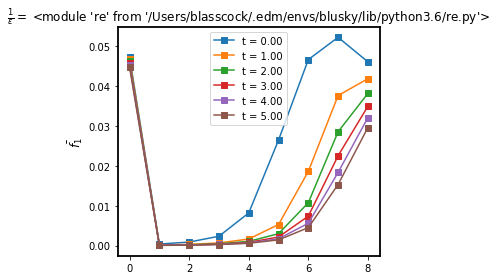

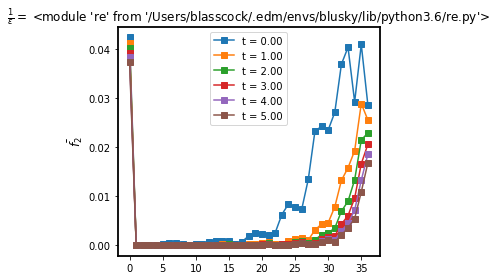

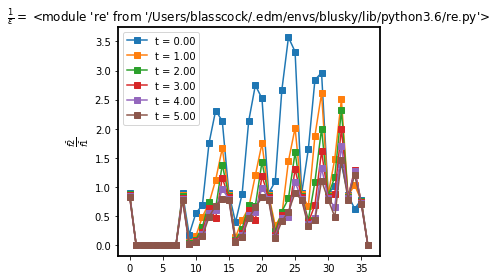

In [15]:

f1s = np.zeros((0, J))
f2f1s = np.zeros((0, J*(J-1)//2))

step = 10 #interval between time snapshots
f2f1arr = np.zeros((len(range(0, total, step)), f2f1s.shape[1]))
Re  = Re

var = var # Plot on slide 18 made with variance = 7

fig1 = plt.figure()
fig2 = plt.figure()
fig3 = plt.figure()

samples = load_data(Re = Re, total = total, var = var)

for i in range(0, total, step):
  #  print(i)
    result, normresult, ratio, norm_ratio = transform(samples[i], N, model, J)
    f = np.squeeze(np.array(result)[0:J])

    f2 = np.squeeze(np.array(result)[J:])

    f2divnew = np.zeros(len(f2))


    # #f2/f1 calculation - assumes a single value for each scale
    for l in range(0, J):
        f2divnew[l*J-conversion(l+1):(l+1)*J-conversion(l+2)] =  np.squeeze(result)[(l+1)*J-conversion(l+1):(l+2)*J-conversion(l+2)]/f[l]

    tmax = 6.0 #duration of the simulation
    ax1 = fig1.add_subplot(1, 1, 1)  # create an axes object in the figure

    f = np.squeeze(np.array(result[0:J]))
    f2 = np.squeeze(np.array(result[J:]))

    f1s = np.vstack((f1s, f[0:J].reshape(1, -1)))


    ax1.plot(f, 's-', label = "t = "+ "%.2f" %  (tmax*i/60))                
    ax2 = fig2.add_subplot(1, 1, 1)
    ax2.plot(f2, 's-', label = "t = " + "%.2f" % (tmax*i/60))
    ax3 = fig3.add_subplot(1, 1, 1)
    ax3.plot(f2divnew, 's-', label = "t = " + "%.2f" % (tmax*i/60))

    ax1.set_ylabel(r"$\bar{f_1}$")
    ax2.set_ylabel(r"$\bar{f_2}$")
    ax3.set_ylabel(r"$\frac{\bar{f2}}{\bar{f1}}$")
    ax1.legend()
    ax2.legend()
    ax3.legend()

    ax1.set_title(r"$\frac{1}{\epsilon}=$ " + str(re))
    ax2.set_title(r"$\frac{1}{\epsilon}=$ " + str(re))
    ax3.set_title(r"$\frac{1}{\epsilon}=$ " + str(re))


plt.show()
keras_backend.clear_session()



# First, second order, and rate coefficients with Dirac Normalization

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048, 1)      0                                            
__________________________________________________________________________________________________
reflection_padding1d_1 (Reflect (None, 4096, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
reflection_padding1d_2 (Reflect (None, 4103, 1)      0           reflection_padding1d_1[0][0]     
__________________________________________________________________________________________________
reflection_padding1d_3 (Reflect (None, 4111, 1)      0           reflection_padding1d_1[0][0]     
__________________________________________________________________________________________________
reflection

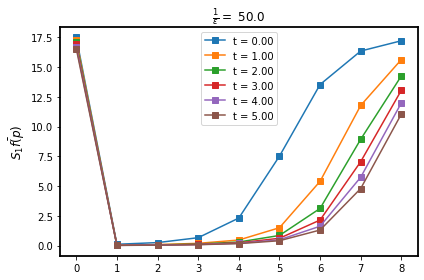

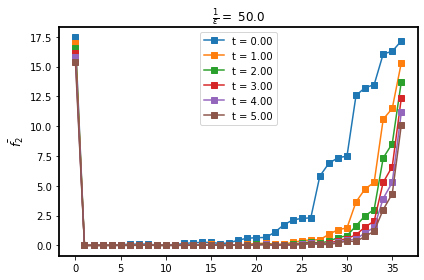

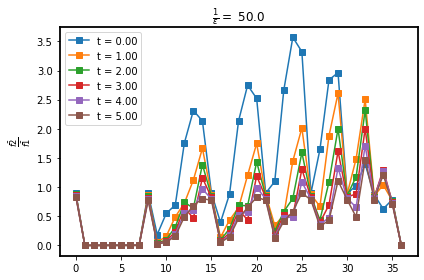

In [16]:
# initialize figures
N = 256*8
order = 2
J = 9
sample_rate = 0.001
f2f1s = np.zeros((0, J*(J-1)//2))

total = 60 # total number of timesteps



model = transform_model(N = N, order = order, sample_rate = sample_rate, J = J)

f1s = np.zeros((0, J))
f2f1s = np.zeros((0, J*(J-1)//2))

step = 10
f2f1arr = np.zeros((len(range(0, total, step)), f2f1s.shape[1]))

fig1 = plt.figure()
fig2 = plt.figure()
fig3 = plt.figure()
re = Re
std = var
samples = load_data(Re = Re, total = total, var = var)

for i in range(0, total, step):
  #  print(i)
    result, normresult, ratio, norm_ratio = transform(samples[i], N, model, J)
    f = np.squeeze(np.array(result)[0:J])

    f2 = np.squeeze(np.array(result)[J:])

    f2divnew = np.zeros(len(f2))


    # #f2/f1 calculation - assumes a single value for each scale
    for l in range(0, J):
        f2divnew[l*J-conversion(l+1):(l+1)*J-conversion(l+2)] =  np.squeeze(result)[(l+1)*J-conversion(l+1):(l+2)*J-conversion(l+2)]/f[l]

    tmax = 6.0 #duration of the simulation
    ax1 = fig1.add_subplot(1, 1, 1)  # create an axes object in the figure

    f = np.squeeze(np.array(normresult[0:J]))
    f2 = np.squeeze(np.array(normresult[J:]))

    f1s = np.vstack((f1s, f[0:J].reshape(1, -1)))
    f2f1s = np.vstack((f2f1s, np.array(norm_ratio).reshape(1, -1)))

    ax1.plot(f, 's-', label = "t = "+ "%.2f" %  (tmax*i/60))                
    ax2 = fig2.add_subplot(1, 1, 1)
    ax2.plot(f2, 's-', label = "t = " + "%.2f" % (tmax*i/60))
    ax3 = fig3.add_subplot(1, 1, 1)
    ax3.plot(f2divnew, 's-', label = "t = " + "%.2f" % (tmax*i/60))

    ax1.set_ylabel(r"$\bar{S_1 f(p)}$")
    ax2.set_ylabel(r"$\bar{f_2}$")
    ax3.set_ylabel(r"$\frac{\bar{f2}}{\bar{f1}}$")
    ax1.legend()
    ax2.legend()
    ax3.legend()

    ax1.set_title(r"$\frac{1}{\epsilon}=$ " + str(re))
    ax2.set_title(r"$\frac{1}{\epsilon}=$ " + str(re))
    ax3.set_title(r"$\frac{1}{\epsilon}=$ " + str(re))


plt.show()
keras_backend.clear_session()



# Plotting First Order Coefficients over time

Generate MST data at every timestep:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048, 1)      0                                            
__________________________________________________________________________________________________
reflection_padding1d_1 (Reflect (None, 4096, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
reflection_padding1d_2 (Reflect (None, 4103, 1)      0           reflection_padding1d_1[0][0]     
__________________________________________________________________________________________________
reflection_padding1d_3 (Reflect (None, 4111, 1)      0           reflection_padding1d_1[0][0]     
__________________________________________________________________________________________________
reflection

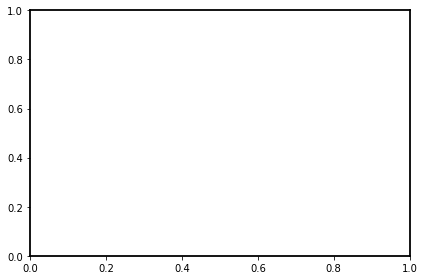

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
# initialize figures
N = 256*8
order = 2
J = 9
sample_rate = 0.001
f2f1s = np.zeros((0, J*(J-1)//2))

total = 60 # total number of timesteps



model = transform_model(N = N, order = order, sample_rate = sample_rate, J = J)

f1s = np.zeros((0, J))
f2f1s = np.zeros((0, J*(J-1)//2))

step = 1
f2f1arr = np.zeros((len(range(0, total, step)), f2f1s.shape[1]))

fig1 = plt.figure()
fig2 = plt.figure()
fig3 = plt.figure()
re = Re
std = var
samples = load_data(Re = Re, total = total, var = var)

for i in range(0, total, step):
  #  print(i)
    result, normresult, ratio, norm_ratio = transform(samples[i], N, model, J)
    f = np.squeeze(np.array(result)[0:J])

    f2 = np.squeeze(np.array(result)[J:])

    f2divnew = np.zeros(len(f2))


    # #f2/f1 calculation - assumes a single value for each scale
    for l in range(0, J):
        f2divnew[l*J-conversion(l+1):(l+1)*J-conversion(l+2)] =  np.squeeze(result)[(l+1)*J-conversion(l+1):(l+2)*J-conversion(l+2)]/f[l]

    tmax = 6.0 #duration of the simulation
    ax1 = fig1.add_subplot(1, 1, 1)  # create an axes object in the figure

    f = np.squeeze(np.array(normresult[0:J]))
    f2 = np.squeeze(np.array(normresult[J:]))

    f1s = np.vstack((f1s, f[0:J].reshape(1, -1)))
    f2f1s = np.vstack((f2f1s, np.array(norm_ratio).reshape(1, -1)))

plt.show()
keras_backend.clear_session()



Text(0.5, 1.0, 'First Order Coefficients over time')

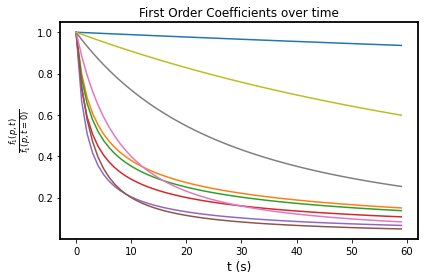

In [18]:
for i in range(J):
    plt.plot(f1s[:, i]/f1s[0, i], label = "p = " + str(i + 1))
plt.xlabel("t (s)")
plt.ylabel(r'$\frac{f_1(p, t)}{f_1(p, t = 0)}$')
plt.title("First Order Coefficients over time")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048, 1)      0                                            
__________________________________________________________________________________________________
reflection_padding1d_1 (Reflect (None, 4096, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
reflection_padding1d_2 (Reflect (None, 4103, 1)      0           reflection_padding1d_1[0][0]     
__________________________________________________________________________________________________
reflection_padding1d_3 (Reflect (None, 4111, 1)      0           reflection_padding1d_1[0][0]     
__________________________________________________________________________________________________
reflection

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

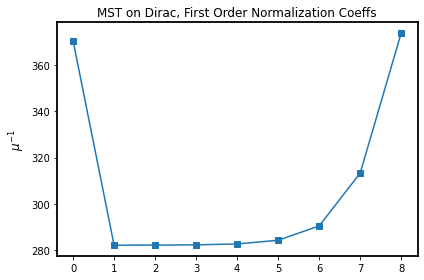

In [19]:
# initialize figures
N = 256*8
order = 2
J = 9
sample_rate = 0.001
f2f1s = np.zeros((0, J*(J-1)//2))

total = 60 # total number of timesteps



model = transform_model(N = N, order = order, sample_rate = sample_rate, J = J)

f1s = np.zeros((0, J))
f2f1s = np.zeros((0, J*(J-1)//2))

step = 1
f2f1arr = np.zeros((len(range(0, total, step)), f2f1s.shape[1]))

fig1 = plt.figure()
fig2 = plt.figure()
fig3 = plt.figure()

samples = load_data(Re, total, var)

result, normresult, ratio, norm_ratio, delta = transform_get_delta(samples[0], N, model, J)
plt.plot(1/np.squeeze(np.array(delta[:9])), 's-')
plt.ylabel(r'$\mu^{-1}$')
plt.title("MST on Dirac, First Order Normalization Coeffs")
keras_backend.clear_session()

